<a href="https://colab.research.google.com/github/achmadbadri/UjiCoba/blob/main/BBCA_4_16_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

In [ ]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style
from google.colab import files
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,31)
df = web.DataReader("BBCA.JK", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2018,11,13)
end = datetime.datetime(2019,12,31)
test_df = web.DataReader("BBCA.JK", 'yahoo', start, end) 
print(df.shape)
print(test_df.shape)

(1251, 6)
(292, 6)


In [ ]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1251,)


In [ ]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1215, 36, 1)
X_train:
[[8841.38378906]
 [8570.72753906]
 [8435.40136719]
 [8457.95410156]
 [8412.84667969]
 [8480.51171875]
 [8480.51171875]
 [8841.38378906]
 [8976.71191406]
 [9021.8203125 ]
 [8931.6015625 ]
 [8863.93652344]
 [8886.4921875 ]
 [8931.6015625 ]
 [9202.25878906]
 [9179.70117188]
 [8841.38378906]
 [9021.8203125 ]
 [9021.8203125 ]
 [8954.15722656]
 [8863.93652344]
 [8886.4921875 ]
 [8976.71191406]
 [9157.14746094]
 [9247.36621094]
 [9066.92773438]
 [9157.14746094]
 [9292.47460938]
 [9247.36621094]
 [9360.13769531]
 [9450.35839844]
 [9382.69140625]
 [9247.36621094]
 [9382.69140625]
 [9427.80078125]
 [9382.69140625]]


y_train: [[9360.13769531]]



In [ ]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 64, return_sequences = False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 32,  activation='relu'))
model.add(Dense(units = 16, activation= 'linear'))
model.add(Dense(units = 1))
# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
85/85 [==============================] - 7s 54ms/step - loss: 0.0182 - val_loss: 0.0018
Epoch 2/20
85/85 [==============================] - 4s 44ms/step - loss: 7.9592e-04 - val_loss: 0.0010
Epoch 3/20
85/85 [==============================] - 4s 46ms/step - loss: 7.4813e-04 - val_loss: 7.9782e-04
Epoch 4/20
85/85 [==============================] - 4s 46ms/step - loss: 6.3613e-04 - val_loss: 0.0029
Epoch 5/20
85/85 [==============================] - 4s 45ms/step - loss: 5.4468e-04 - val_loss: 0.0010
Epoch 6/20
85/85 [==============================] - 4s 44ms/step - loss: 6.1984e-04 - val_loss: 0.0016
Epoch 7/20
85/85 [==============================] - 4s 44ms/step - loss: 5.5700e-04 - val_loss: 6.5485e-04
Epoch 8/20
85/85 [==============================] - 4s 44ms/step - loss: 4.9407e-04 - val_loss: 0.0020
Epoch 9/20
85/85 [==============================] - 4s 44ms/step - loss: 4.6461e-04 - val_loss: 6.5183e-04
Epoch 10/20
85/85 [==============================] - 4s 44ms/step

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 36, 128)           66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

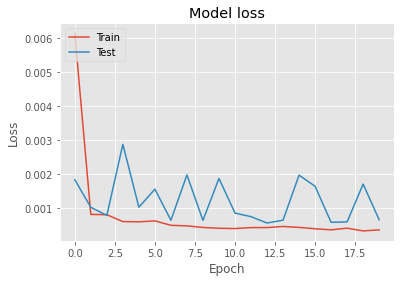

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


In [ ]:
predicted_y = pd.DataFrame(predicted_y)
org_y = pd.DataFrame(org_y)
describe = pd.DataFrame()
describe['True Price'] = org_y[0]
describe['Prediction'] = predicted_y[0]
describe['difference'] = org_y[0] - predicted_y[0]
describe['MAPE (%)'] = abs(describe['difference']/org_y[0]*100)
describe.describe()

,True Price,Prediction,difference,MAPE (%)
count,256.000000,256.000000,256.000000,256.000000
mean,28201.570602,28395.753906,-194.184334,1.171020
std,1824.618878,1756.925781,379.180469,1.021065
min,24727.080078,25138.416016,-1924.435547,0.004028
25%,26350.091797,26640.647461,-381.909180,0.517233
50%,28590.111328,28820.549805,-233.531250,0.953478
75%,29637.851562,29723.392578,19.946289,1.521844
max,32643.193359,32368.958984,1555.718750,7.712204


In [ ]:
describe.head(10)

,True Price,Prediction,difference,MAPE (%)
0,25013.494141,25138.416016,-124.921875,0.499418
1,24727.080078,25178.554688,-451.474609,1.825831
2,24846.419922,25181.343750,-334.923828,1.347976
3,25037.361328,25181.906250,-144.544922,0.577317
4,25013.494141,25207.937500,-194.443359,0.777354
5,25085.099609,25239.896484,-154.796875,0.617087
6,25085.099609,25281.119141,-196.019531,0.781418
7,25061.228516,25321.335938,-260.107422,1.037888
8,24822.550781,25351.986328,-529.435547,2.132881
9,25108.966797,25338.980469,-230.013672,0.916062


In [ ]:
a = np.array(describe['True Price'])
b = np.array(describe['Prediction'])

# MSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: %.2f" % mean_squared_error(a, b))

# The RMSE
print("RMSE: %.2f" % mean_squared_error(a, b, squared=False))

# The MAE
print("MAE: %.2f" % mean_absolute_error(a, b))

#Mean Absolute Percentange Error
c = (np.mean(np.abs((a - b) / a))) * 100
print('MAPE : ', c)

# Explained variance score: 1 is perfect prediction
from sklearn.metrics import r2_score
print('R2 score: %.2f' % r2_score(a, b))


MSE: 180923.75
RMSE: 425.35
MAE: 325.37
MAPE :  1.1710203508000554
R2 score: 0.95


In [ ]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

38/38 [==============================] - 1s 19ms/step - loss: 3.9020e-04
0.00039020171971060336
8/8 [==============================] - 1s 20ms/step - loss: 6.4903e-04
0.0006490284577012062


In [ ]:
print(model.metrics_names)

['loss']


In [ ]:
graph  = test_df.drop(test_df.index[0:36])
graph.reset_index(inplace=True)
graph.rename(columns = {'index':'Date'})
graph = graph.drop(columns=['High','Low','Open','Volume','Close'])
graph['Predict_Value'] = predicted_y[0]
graph.head()
graph.set_index('Date', inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

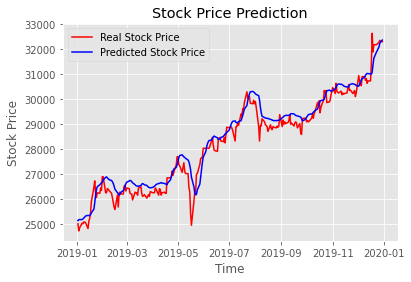

In [ ]:
# plot the results 
plt.plot(graph['Adj Close'], color = 'red', label = 'Real Stock Price')
plt.plot(graph['Predict_Value'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(df['Adj Close'], color = 'black', label = 'Past Stock')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [ ]:
final  = test_df.drop(test_df.index[0:36])
final.reset_index(inplace=True)
final.rename(columns = {'index':'Date'})
final = final.drop(columns=['High','Low','Open','Volume','Close'])
final['Predict_Value'] = predicted_y[0]
final['Selisih'] = final['Adj Close'] - final['Predict_Value']
final['Lost/Risk (%)'] = abs((final['Adj Close'] - final['Predict_Value'])/final['Predict_Value']*100)
final = final.drop(columns=['Adj Close'])

In [ ]:
percent = test_df.drop(test_df.index[0:35])
percent = percent.drop(test_df.index[-1])
percent.reset_index(inplace=True)
percent.rename(columns = {'index':'Date'}) 
percent = percent.drop(columns=['High','Low','Open','Volume','Close'])
percent['Next Day'] = predicted_y
percent['Plus or Minus']= percent['Adj Close'] - percent['Next Day']
percent['Next Day (%)']= abs(((percent['Adj Close'] - percent['Next Day'])/percent['Adj Close'])*100)

In [ ]:
True_Next_Day = test_df.drop(test_df.index[0:35])
True_Next_Day = True_Next_Day.drop(test_df.index[-1])
True_Next_Day.reset_index(inplace=True)
True_Next_Day.rename(columns = {'index':'Date'}) 
True_Next_Day = True_Next_Day.drop(columns=['High','Low','Open','Volume','Close'])
True_Next_Day['True Next Day'] = org_y
True_Next_Day['True Plus or Minus']= (True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])
True_Next_Day['True Next Day (%)']= abs(((True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])/True_Next_Day['Adj Close'])*100)
True_Next_Day = True_Next_Day.drop(columns=['Adj Close','True Next Day'])

In [ ]:
Concating = percent.merge(final, how='outer', on='Date')
Concating = Concating.merge(True_Next_Day, how='outer', on='Date')
#Concating.set_index('Date', inplace=True)
Final_Predict = Concating.copy()
Final_Predict['Harga Saham Hari ini'] = Concating['Adj Close']
Final_Predict['Prediksi Besok'] = Concating['Plus or Minus']
Final_Predict['Harga Besok Sebenarnya'] = Concating['True Plus or Minus']
Final_Predict['Prediksi Besok (%)'] = (Concating['Next Day (%)'])
Final_Predict['Harga Besok Sebenarnya (%)'] = Concating['True Next Day (%)']
Final_Predict['Selisih Prediksi'] = (Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])
Final_Predict['Risk/MAPE(%)'] = abs(((Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])/Final_Predict['Harga Besok Sebenarnya'])*100)
Final_Predict['Risk/MAPE(%)'] = round(Final_Predict['Risk/MAPE(%)'], 2)
Final_Predict = Final_Predict.drop(columns=['Adj Close', 'Next Day', 'Plus or Minus', 'Next Day (%)',
                                            'Predict_Value', 'Selisih', 'Lost/Risk (%)', 'True Plus or Minus',
                                            'True Next Day (%)'])
Final_Predict = Final_Predict.replace(0, np.nan)
Final_Predict = Final_Predict.dropna()
Final_Predict.set_index('Date', inplace=True)
Final_Predict.shape

(229, 7)

In [ ]:
Final_Predict.head()

,Harga Saham Hari ini,Prediksi Besok,Harga Besok Sebenarnya,Prediksi Besok (%),Harga Besok Sebenarnya (%),Selisih Prediksi,Risk/MAPE(%)
Date,,,,,,,
2019-01-01,24822.550781,-315.865234,-190.943359,1.272493,0.769233,124.921875,65.42
2019-01-02,25013.494141,-165.060547,286.414062,0.659886,1.145038,451.474609,157.63
2019-01-03,24727.080078,-454.263672,-119.339844,1.837110,0.482628,334.923828,280.65
2019-01-04,24846.419922,-335.486328,-190.941406,1.350240,0.768487,144.544922,75.70
2019-01-07,25037.361328,-170.576172,23.867188,0.681287,0.095326,194.443359,814.69


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

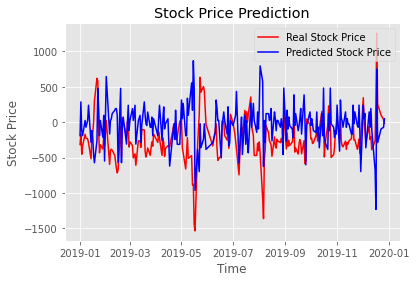

In [ ]:
# plot the results 
plt.plot(Final_Predict['Prediksi Besok'], color = 'red', label = 'Real Stock Price')
plt.plot(Final_Predict['Harga Besok Sebenarnya'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(Final_Predict['Risk/MAPE(%)'], color = 'black', label = 'RISK/MAPE(%)')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [ ]:
#### Mencari Data STAT MODEL

In [ ]:
a = X_test
a = np.reshape(a, (-1, 36))
a = scaler.inverse_transform(a)
a = pd.DataFrame(a)

In [ ]:
b = y_test
#b = np.reshape(b, (-1, 36))
b = scaler.inverse_transform(b)
b = pd.DataFrame(b)

In [ ]:
#OLS Model
import statsmodels.api as sm
X = a
Y = b
X = sm.add_constant(X)
model_ols = sm.OLS(Y,X)
results = model_ols.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     320.6
Date:                Fri, 16 Apr 2021   Prob (F-statistic):          1.33e-169
Time:                        02:55:42   Log-Likelihood:                -1775.2
No. Observations:                 256   AIC:                             3624.
Df Residuals:                     219   BIC:                             3756.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.9326    270.856      0.358      0.721    -436.886     630.751
0             -0.0425      0.070     -0.605      0.546      -0.181       0.096
1              0.0127      0.095      0.133      0.894      -0.175       0.200
2              0.0921      0.095      0.969      0.334      -0.095       0.279
3              0.0470      0.095      0.493      0.622      -0.141       0.235
4             -0.1529      0.095     -1.617      0.107      -0.339       0.034
5              0.1427      0.094      1.518      0.131      -0.043       0.328
6             -0.1075      0.094     -1.143      0.254      -0.293       0.078
7              0.0609      0.094      0.646      0.519      -0.125       0.246
8             -0.0525      0.094     -0.557      0.578      -0.239       0.133
9              0.0568      0.094      0.602      0.548      -0.129       0.243
10            -0.0114      0.094     -0.121      0.904      -0.198       0.175
11            -0.1102      0.094     -1.177      0.240      -0.295       0.074
12             0.0485      0.094      0.517      0.605      -0.136       0.233
13             0.0761      0.094      0.810      0.419      -0.109       0.261
14            -0.1063      0.095     -1.119      0.264      -0.293       0.081
15             0.1300      0.096      1.355      0.177      -0.059       0.319
16            -0.1117      0.095     -1.172      0.243      -0.300       0.076
17             0.1646      0.095      1.740      0.083      -0.022       0.351
18            -0.0871      0.094     -0.925      0.356      -0.273       0.098
19             0.0165      0.095      0.173      0.863      -0.171       0.204
20            -0.0020      0.096     -0.021      0.983      -0.192       0.188
21            -0.0687      0.097     -0.709      0.479      -0.260       0.122
22             0.1484      0.097      1.533      0.127      -0.042       0.339
23            -0.1227      0.096     -1.273      0.204      -0.313       0.067
24             0.0734      0.096      0.767      0.444      -0.115       0.262
25             0.0278      0.096      0.290      0.772      -0.161       0.216
26            -0.0549      0.097     -0.567      0.571      -0.246       0.136
27            -0.1560      0.099     -1.582      0.115      -0.350       0.038
28             0.1545      0.099      1.561      0.120      -0.041       0.349
29            -0.1007      0.099     -1.022      0.308      -0.295       0.093
30             0.1221      0.093      1.317      0.189      -0.061       0.305
31            -0.0226      0.092     -0.246      0.806      -0.203       0.158
32            -0.0536      0.092     -0.582      0.561      -0.235       0.128
33             0.0865      0.092      0.940      0.348      -0.095       0.268
34            -0.0308      0.092     -0.333      0.739      -0.213       0.151
35